In [21]:
#image dataset을 load하고 preprocessing(전처리)하는 두 가지 방법
#1. 고급 keras preprocessing utility와 layer 사용
#2. tf.data를 사용하여 처음부터 자체 입력 파이프라인 작성

In [22]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [23]:
print(tf.__version__)

2.8.0


In [24]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [25]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


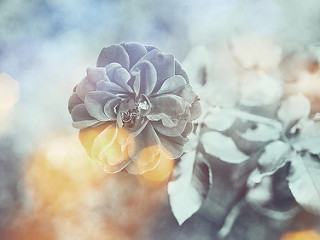

In [26]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

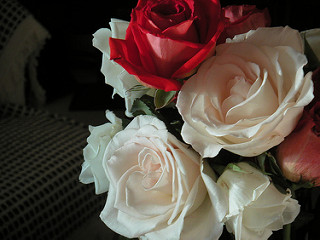

In [27]:
PIL.Image.open(str(roses[1]))

In [28]:
#여기서부터 tf.keras.preprocessing을 사용하여 로드해보겠습니다.
batch_size = 32
img_height = 180
img_width = 180

In [29]:
#검증 분할(데이터 분할). 
# validation : 0.2
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [30]:
#검증 분할(데이터 분할).
# validation : 0.2
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [31]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


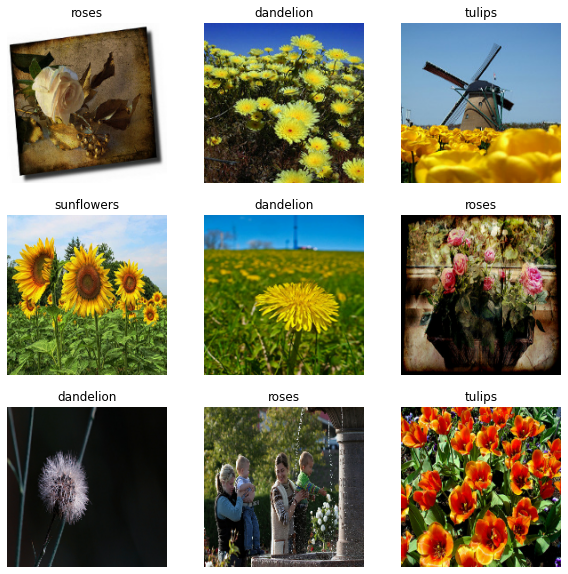

In [32]:
#데이터 시각화하기
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [33]:
#180x180x3(RGB)형상의 32개 이미지 묶음임을 확인
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [34]:
#RGB값을 0~1 범위로 만들기.
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [35]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) #lambda: 함수를 한 줄로 만들어줌
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.96902645


In [36]:
#성능을 위한 데이터세트 구상하기
#버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성하도록 해보자.
#이를 위해서는 두 가지 method 사용해야한다.
#1. .cache(): 첫 번째 epoch동안 디스크에서 이미지 로드 후 이 이미지를 메모리에 유지.
#2. .prefetch(): 훈련 중에 데이터 전처리 및 모델 실행과 겹친다.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [38]:
#training model
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(), #가장 큰 값 뽑아내기
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [39]:
model.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [41]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 112s 1s/step - loss: 1.2420 - accuracy: 0.4612 - val_loss: 1.0684 - val_accuracy: 0.5450
Epoch 2/3
92/92 [==============================] - 105s 1s/step - loss: 1.0038 - accuracy: 0.6049 - val_loss: 0.9644 - val_accuracy: 0.6049
Epoch 3/3
92/92 [==============================] - 104s 1s/step - loss: 0.8613 - accuracy: 0.6652 - val_loss: 0.9292 - val_accuracy: 0.6294


In [43]:
#미세 제어를 위한 tf.data 사용
#보다 세밀한 제어를 위해 tf.data를 사용하여 '자체 입력 파이프라인'을 작성한다.
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [44]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/roses/8671682526_7058143c99.jpg'
b'/root/.keras/datasets/flower_photos/tulips/14066056226_d8564a083e_m.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/8719032054_9a3ce4f0ff.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/7510285306_ba8f80c382_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/5249566718_6109630c83_m.jpg'


In [46]:
#파일의 트리 구조를 사용하여 class_names 목록을 compile
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [47]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [48]:
print(tf.data.experimental.cardinality(train_ds).numpy()) #cardinality가 높으면 중복이 적다는 뜻(ex. 주민번호)
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [49]:
#파일 경로를 (img, label) 쌍으로 변환하는 함수
def get_label(file_path):
  #convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  #The second to last is the class-directory
  one_hot = parts[-2] == class_names
  #Integer encode the label
  return tf.argmax(one_hot)

In [51]:
def decode_img(img):
  #convert the compressed string to a 3D unit8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  #resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [53]:
def process_path(file_path):
  label = get_label(file_path)
  #load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [54]:
#Dataset.map을 사용하여 image, label 쌍의 dataset을 작성한다.
#Set 'num_parallel_calls' so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [55]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  4


In [56]:
#이러한 dataset으로 모델을 훈련하려면 다음 3가지가 필요하다.
#잘 섞는다, 배치 처리한다, 가능한 빨리 배치를 사용할 수 있어야 한다.
#이들은 tf.data API를 사용하여 추가할 수 있다
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

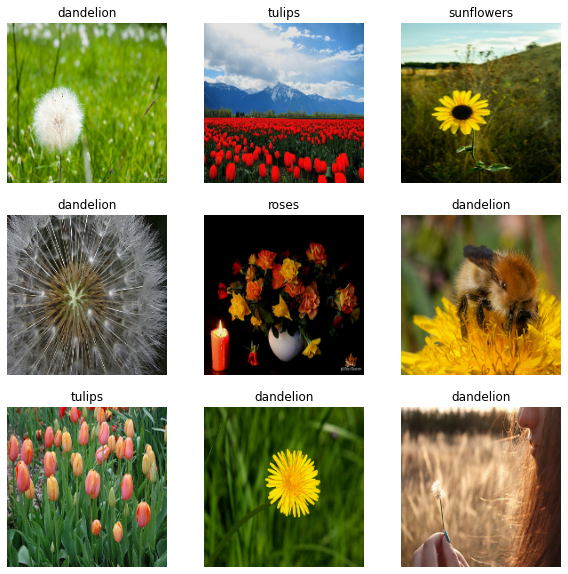

In [57]:
#데이터 시각화
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [58]:
#모델 계속 훈련하기
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 [==============================] - 167s 2s/step - loss: 0.7625 - accuracy: 0.7071 - val_loss: 0.8795 - val_accuracy: 0.6553
Epoch 2/3
92/92 [==============================] - 121s 1s/step - loss: 0.5939 - accuracy: 0.7776 - val_loss: 0.7753 - val_accuracy: 0.7193
Epoch 3/3
92/92 [==============================] - 103s 1s/step - loss: 0.4068 - accuracy: 0.8515 - val_loss: 0.8047 - val_accuracy: 0.7221


In [63]:
#tensorflow dataset 사용하기
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info = True,
    as_supervised=True,
)

In [64]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


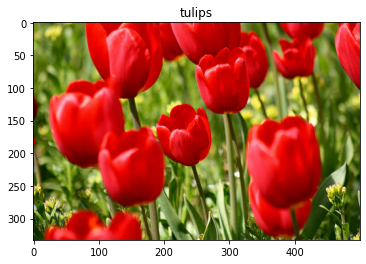

In [65]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [66]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)